# Neural networks 

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import numpy as np

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Import Theano 

In [2]:
env MKL_THREADING_LAYER=GNU

env: MKL_THREADING_LAYER=GNU


In [3]:
import theano
import theano.tensor as T

### Perceptron implementation with `Theano`

After studing `Theano`'s syntax, we are going to use it to define a neural network. At first, let's define a neuron which calculates the `AND` logic function. The neuron's model is:

<img src="img/perceptron-model.png" alt="Drawing" style="width: 200px;"/>

Being: $x$ the input vector and $w$ the weight vector, and $b$ the bias.

In [4]:
# Definition of the symbolic variables
x = T.vector('x')

# Definition of shared variables
w = theano.shared(np.array([1, 1], dtype = theano.config.floatX))
b = theano.shared(-1.5)

# Definition of neuron
z = T.dot(x, w) + b
a = T.switch(T.lt(z, 0), 0, 1)

# Creation of the function
neuron = theano.function([x], a)

# Input dataset
inputs = [[0, 0], [0, 1], [1, 0], [1, 1]]

# Let's iterate above the inputs
for i in range(len(inputs)) :
    t = inputs[i]
    out = neuron(t)
    
    print('The result for [%d, %d] is %d' % (t[0], t[1], out))

The result for [0, 0] is 0
The result for [0, 1] is 0
The result for [1, 0] is 0
The result for [1, 1] is 1


### Types of neuron 

There are serveral kind of neurons, and `Theano` gives its implementation on `nnet` library. Here, there are some of them: 

- sigmoid: $$a(z) = \frac{1}{1 + e^{-z}}$$
- softplus: $$a(z) = \log_e{(1 + e^z)}$$
- softmax: $$a_{ij}(z) = \frac{e^{z_{ij}}}{\sum_k{e^{z_{ik}}}}$$
- softsign: $$a(z) = \frac{1}{1 + |z|}$$

### Backpropagation 

For trainning the neural network, we need an effort function. We can implement this function, but `Theano` has some of them on `nnet` library. However, we are going to use the cross entropy function given on `T.nnet.binary_crossentropy()` and its definition is:

$$ J(z) = - \sum_{i=1}^{n}{(a_i * \log{(a(z_i))} + (1 - a_i) * \log{(1 - a(z_i)})} $$

Now, we are going to use this effort function to train a neural network:

In [5]:
# Let's define functions for init the weights the random way:
def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

In [6]:
# Seed
rng = np.random.RandomState(1)

# Definition of symbolics variables
x = T.matrix('x')
w = init_weights((2,)) # A vector with 2 values
b = theano.shared(1.0)
learning_rate = 0.01

# Definition of neuron
z = T.dot(x, w) + b
a = T.nnet.sigmoid(z)

# Definition of effort function
a_hat = T.vector('a_hat')
cost = T.nnet.binary_crossentropy(a, a_hat).sum()

# Effort function's gradient
dw, db = T.grad(cost, [w, b])

# Train function's definition
train = theano.function(inputs = [x, a_hat],
                        outputs = [a, cost],
                        updates = [[w, w - learning_rate * dw], [b, b - learning_rate * db]])

The neurnal network results are:
The result for [0, 0] is 0.00
The result for [0, 1] is 0.05
The result for [1, 0] is 0.05
The result for [1, 1] is 0.93

The w vector is [5.55, 5.55]
The b vector is -8.50


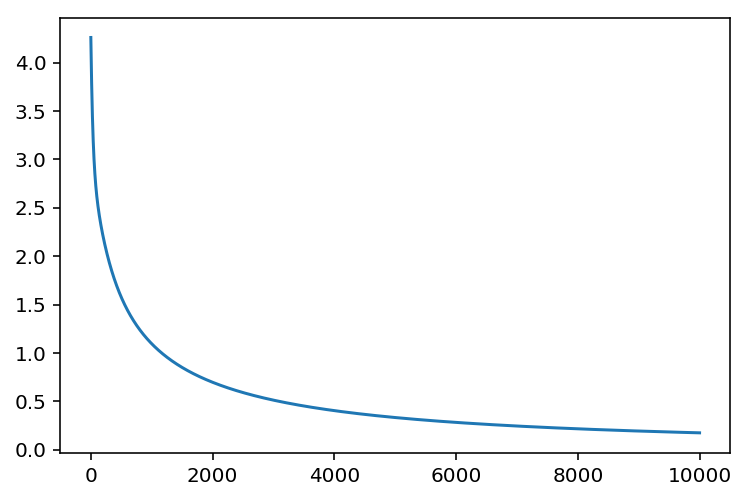

In [7]:
## Train dataset
inputs = [[0, 0], [0, 1], [1, 0], [1, 1]]
outputs = [0,0,0,1]

# Let's iterate 10.000 times above train dataset
cost = []
for iteration in range(10000) :
    pred, cost_iter = train(inputs, outputs)
    # Append the cost. Don't append the pred value because we only want the last value
    cost.append(cost_iter)
    
# Print the results
print('The neurnal network results are:')
for i in range(len(inputs)) :
    print('The result for [%d, %d] is %.2f' % (inputs[i][0], inputs[i][1], pred[i]))
    
# Print the results of weights and bias
print()
print('The w vector is [%.2f, %.2f]' % (w.get_value()[0], w.get_value()[1]))
print('The b vector is %.2f' % (b.get_value()))

# Plot the effort function according to number of iterations
plt.plot(cost)

### Neural network with two layers 

Now, we are going to implement a neural network with two layers. In the first one, let's use two neurons and in the second one, one neuron. The model of this neural network is:

<img src="img/neural-network-two-layers-model.png" alt="Drawing" style="width: 400px;"/>

With this neural network model, we are going to train it for `XNOR` logic function with the following results:

X1 | X2 | out
-- | -- | --
0 | 0 | 1
0 | 1 | 0
1 | 0 | 0
1 | 1 | 1

In [8]:
# Let's define functions for init the weights the random way:
def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

In [9]:
# Seed
rng = np.random.RandomState(1)

# Let's define the symbolics variables
x = T.matrix('x')
w1 = init_weights((2,))
w2 = init_weights((2,))
w3 = init_weights((2,))
b1 = theano.shared(1.)
b2 = theano.shared(1.)
learning_rate = 0.1

# Let's define the neurons and its relationships
a1 = T.nnet.sigmoid(T.dot(x, w1) - b1)
a2 = T.nnet.sigmoid(T.dot(x, w2) - b1)
# Let's join the output of the first neurons for input the last neuron
x2 = T.stack([a1, a2], axis = 1)
a3 = T.nnet.sigmoid(T.dot(x2, w3 - b2))

# Let's define the effort function and its gradient
a_hat = T.vector('a_hat')
cost = T.nnet.binary_crossentropy(a3, a_hat).sum()
dw1, dw2, dw3, db1, db2 = T.grad(cost, [w1, w2, w3, b1, b2])

# Let's define the train function
train = theano.function(inputs = [x, a_hat],
                        outputs = [a3, cost],
                        updates = [
                            [w1, w1 - learning_rate * dw1],
                            [w2, w2 - learning_rate * dw2],
                            [w3, w3 - learning_rate * dw3],
                            [b1, b1 - learning_rate * db1],
                            [b2, b2 - learning_rate * db2]
                        ])

The neurnal network results are:
The result for [0, 0] is 1.00
The result for [0, 1] is 0.00
The result for [1, 0] is 0.00
The result for [1, 1] is 0.50

The w1 vector is [-9.00, -9.00]
The w2 vector is [-13.53, -13.53]
The w3 vector is [-12.56, 15.74]
The b1 vector is -10.06
The b2 vector is -2.17


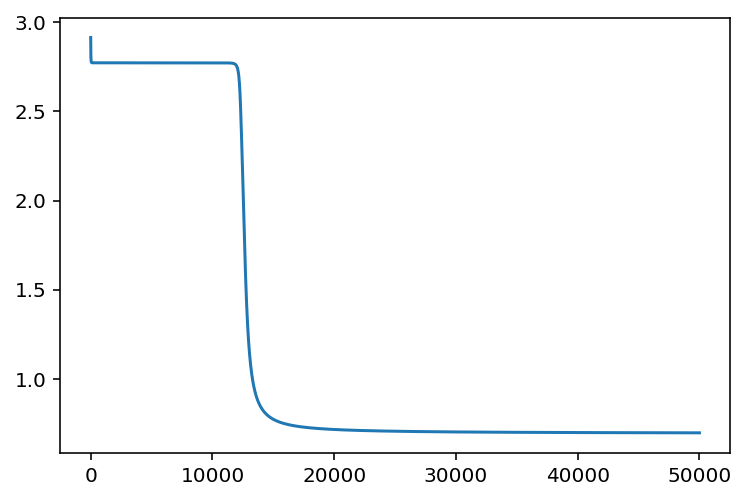

In [10]:
## Train dataset
inputs = [[0, 0], [0, 1], [1, 0], [1, 1]]
outputs = [1, 0, 0, 1]

# Let's iterate 50.000 times above train dataset
cost = []
for iteration in range(50000) :
    pred, cost_iter = train(inputs, outputs)
    # Append the cost. Don't append the pred value because we only want the last value
    cost.append(cost_iter)
    
# Print the results
print('The neurnal network results are:')
for i in range(len(inputs)) :
    print('The result for [%d, %d] is %.2f' % (inputs[i][0], inputs[i][1], pred[i]))
    
# Print the results of weights and bias
print()
print('The w1 vector is [%.2f, %.2f]' % (w1.get_value()[0], w1.get_value()[1]))
print('The w2 vector is [%.2f, %.2f]' % (w2.get_value()[0], w2.get_value()[1]))
print('The w3 vector is [%.2f, %.2f]' % (w3.get_value()[0], w3.get_value()[1]))
print('The b1 vector is %.2f' % (b1.get_value()))
print('The b2 vector is %.2f' % (b2.get_value()))

# Plot the effort function according to number of iterations
plt.plot(cost)

There is another way to make this neural network. This way is the following:

In [11]:
# Let's define functions for init the weights the random way:
def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

In [12]:
# Seed
rng = np.random.RandomState(1)

# Symbolic variable 
x = T.matrix('x')
learning_rate = 0.1

# Bias
b1 = theano.shared(1.)
b2 = theano.shared(1.)

# Random weights
w1 = init_weights((2, 3)) # Three neurons with 2 inputs and 3 outputs
w2 = init_weights((3, 1)) # One neuron with 3 inputs and 1 output


# Let's define the neurons and its relationships
a1 = T.nnet.sigmoid(T.dot(x, w1) - b1)  # First three neurons
a2 = T.nnet.sigmoid(T.dot(a1, w2) - b2) # Last one neuron
a3 = T.flatten(a2) # Flatten the result for having the same format that input

# Let's define the effort function and its gradient
a_hat = T.vector('a_hat')
cost = T.nnet.binary_crossentropy(a3, a_hat).sum()
dw1, dw2, db1, db2 = T.grad(cost, [w1, w2, b1, b2])

# Let's define the train function
train = theano.function(inputs = [x, a_hat],
                        outputs = [a3, cost],
                        updates = [
                            [w1, w1 - learning_rate * dw1],
                            [w2, w2 - learning_rate * dw2],
                            [b1, b1 - learning_rate * db1],
                            [b2, b2 - learning_rate * db2]
                        ])

The neurnal network results are:
The result for [0, 0] is 0.33
The result for [0, 1] is 0.33
The result for [1, 0] is 0.33
The result for [1, 1] is 1.00


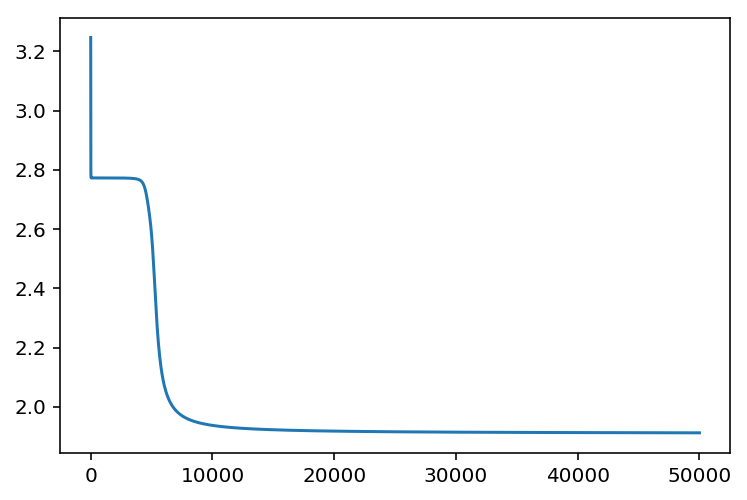

In [13]:
## Train dataset
inputs = [[0, 0], [0, 1], [1, 0], [1, 1]]
outputs = [1, 0, 0, 1]

# Let's iterate 50.000 times above train dataset
cost = []
for iteration in range(50000) :
    pred, cost_iter = train(inputs, outputs)
    # Append the cost. Don't append the pred value because we only want the last value
    cost.append(cost_iter)
    
# Print the results
print('The neurnal network results are:')
for i in range(len(inputs)) :
    print('The result for [%d, %d] is %.2f' % (inputs[i][0], inputs[i][1], pred[i]))
    
# Plot the effort function according to number of iterations
plt.plot(cost)